# NYC Taxi - Data exploration and cleaning

This notebook creates a brief report that summarizes the core 
features of the data and calls out interesting trends, etc

In [1]:
import extraction as ext
import preprocessing as prep
import visualization as vis
import importlib
import pandas as pd
import geopandas as gpd
import yaml
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics
import pyspark.sql.functions as func
import matplotlib.pyplot as plt

### Extract, preprocess and add new features


In [2]:
importlib.reload(prep)
# Get all the datasets and apply preprocessing 

with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

spark = SparkSession.builder.appName("NYC_Taxi").getOrCreate()

spark.conf.set("spark.sql.execution.arrow.enabled","true")        

print(f"Get Taxi Data")
psdf_taxi = ext.get_taxi_data(spark, cfg)

print(f"Get zones")
df_zones = ext.get_zones(cfg)
print(f"Clean zones")
df_zones = prep.clean_zone_data(df_zones)
psdf_zones=spark.createDataFrame(df_zones)

gdf_zones_shp = ext.get_zones_shapefile(cfg)
gdf_zones_shp = prep.clean_zone_shp_data(gdf_zones_shp)
gdf_zones_shp = prep.add_features_shp_data(gdf_zones_shp)
psdf_zones_shp = spark.createDataFrame(gdf_zones_shp[["OBJECTID", "lat", "lon"]])

print(f"Add features taxi")
psdf_taxi = prep.add_features_taxi_data(psdf_taxi, psdf_zones, psdf_zones_shp)

print(f"Clean Taxi Data")
psdf_taxi = prep.clean_taxi_data(psdf_taxi, cfg)

print(f"SPDF Taxi size: {psdf_taxi.count()}")

gdf_zones_shp = ext.get_zones_shapefile(cfg)
gdf_zones_shp = prep.clean_zone_shp_data(gdf_zones_shp)

Get Taxi Data
Already downloaded file: yellow_tripdata_2017-01.parquet
Already downloaded file: yellow_tripdata_2017-03.parquet
Already downloaded file: yellow_tripdata_2017-06.parquet
Already downloaded file: yellow_tripdata_2017-11.parquet
Already downloaded file: yellow_tripdata_2017-12.parquet
Get zones
Already downloaded file: taxi+_zone_lookup.csv
Clean zones
Already downloaded file: taxi_zones.shp
Add features taxi
Clean Taxi Data
SPDF Taxi size: 3262778
Already downloaded file: taxi_zones.shp


### Analysis by category variables

In [3]:
replace_map = {'VendorID': {
                   1: 'Creative Mobile Technologies, LLC',
                   2: 'VeriFone Inc'},
                'RateCodeID' : {
                    1: 'Standard rate', 2: 'JFK', 3: 'Newark', 
                    4: 'Nassau or Westchester', 5: 'Negotiated fare', 
                    6: 'Group ride'}
        }

# convert a sample from spark dataframe to pandas dataframe so we
# can use seaborn library for visualizations
df_taxi = psdf_taxi.sample(0.1).toPandas()
df_taxi = df_taxi.replace(replace_map)

VendorID
+--------+------------------+------------------+-------------------+--------------------+
|VendorID|avg(fare_amount)  |avg(tip_amount)   |avg(tip_percentage)|avg(duration_in_min)|
+--------+------------------+------------------+-------------------+--------------------+
|1       |13.004419314833736|2.6468441483427787|18.708807542478098 |14.490511583677568  |
|2       |13.423085345884468|2.728461407732051 |18.580121108952895 |14.740384198877619  |
+--------+------------------+------------------+-------------------+--------------------+



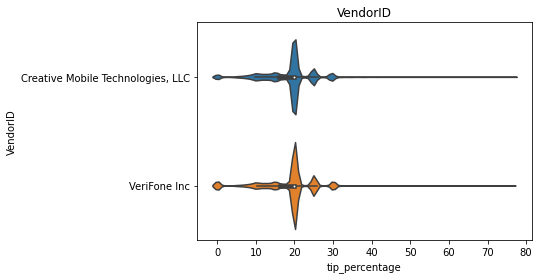

RateCodeID
+----------+------------------+------------------+-------------------+--------------------+
|RateCodeID|avg(fare_amount)  |avg(tip_amount)   |avg(tip_percentage)|avg(duration_in_min)|
+----------+------------------+------------------+-------------------+--------------------+
|null      |39.725789473684216|0.8748387096774193|2.966760486413665  |8.7                 |
|1         |12.094546673551205|2.476503615326007 |18.679788089870907 |13.937286961942334  |
|2         |51.99941379772271 |10.382626471695298|18.017434531036997 |44.1715906133757    |
|3         |67.21164483260553 |12.59856708779785 |16.823987365872757 |39.01027207915026   |
|4         |54.39330601092896 |9.475034695451043 |16.6312511763458   |36.38327668252889   |
|5         |44.49654302826528 |6.163489133400006 |13.056275127311352 |22.457565579014684  |
|6         |2.7               |6.9319999999999995|40.303030303030305 |5.1                 |
+----------+------------------+------------------+-------------------

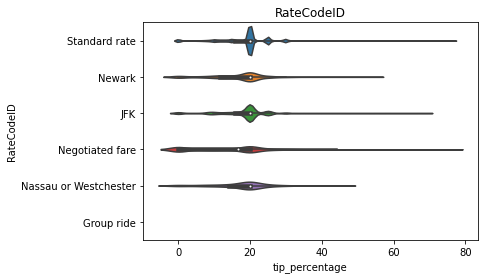

store_and_fwd_flag
+------------------+------------------+------------------+-------------------+--------------------+
|store_and_fwd_flag|avg(fare_amount)  |avg(tip_amount)   |avg(tip_percentage)|avg(duration_in_min)|
+------------------+------------------+------------------+-------------------+--------------------+
|N                 |13.218496869086966|2.6882380547933886|18.637768061756304 |14.61145333542553   |
|Y                 |17.256991492043483|3.5627608473108143|18.737687655826665 |18.7197545621165    |
+------------------+------------------+------------------+-------------------+--------------------+



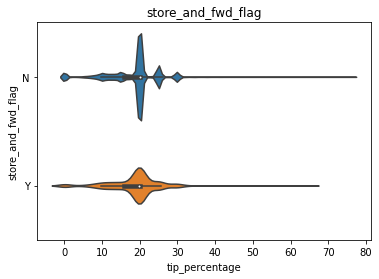

PU_service_zone
+---------------+------------------+-----------------+-------------------+--------------------+
|PU_service_zone|avg(fare_amount)  |avg(tip_amount)  |avg(tip_percentage)|avg(duration_in_min)|
+---------------+------------------+-----------------+-------------------+--------------------+
|Airports       |39.62108047013558 |8.084136664526334|18.424459252965043 |37.08643043375218   |
|Boro Zone      |14.247419727706445|2.671842176617788|17.289782943883605 |14.489245712764994  |
|EWR            |67.21272189349114 |8.488838174273859|12.305355638010699 |5.586607142857142   |
|Unknown        |14.518723541203084|2.861665846860157|18.32003227761771  |14.180322968828847  |
|Yellow Zone    |11.653359136671037|2.379834094945096|18.716873284260206 |13.398914602760547  |
+---------------+------------------+-----------------+-------------------+--------------------+



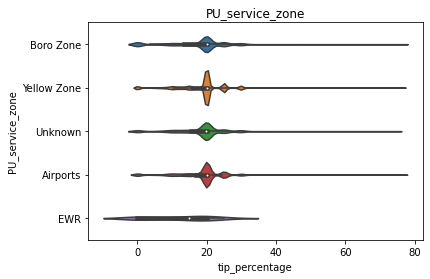

PU_Borough
+-------------+------------------+------------------+-------------------+--------------------+
|PU_Borough   |avg(fare_amount)  |avg(tip_amount)   |avg(tip_percentage)|avg(duration_in_min)|
+-------------+------------------+------------------+-------------------+--------------------+
|Bronx        |17.63431386861314 |2.3793294460641397|12.388850318458344 |16.71351145038168   |
|Brooklyn     |14.41693223044551 |2.829711873427524 |18.498120694365724 |14.980664372360962  |
|EWR          |67.21272189349114 |8.488838174273859 |12.305355638010699 |5.586607142857142   |
|Manhattan    |11.669636842202607|2.3771925458397622|18.67209791349526  |13.392635501681964  |
|Queens       |37.196429715850016|7.551191809090689 |18.284710053569558 |34.72402636243414   |
|Staten Island|25.706349206349206|4.074426229508197 |16.986710551594815 |18.593548387096774  |
|Unknown      |14.518723541203084|2.861665846860157 |18.32003227761771  |14.180322968828847  |
+-------------+------------------+-----

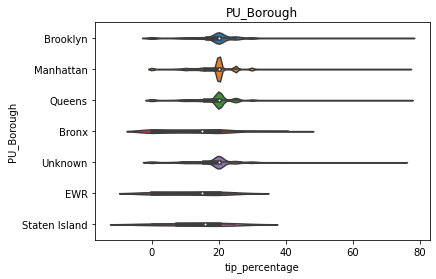

DO_Borough
+-------------+------------------+------------------+-------------------+--------------------+
|DO_Borough   |avg(fare_amount)  |avg(tip_amount)   |avg(tip_percentage)|avg(duration_in_min)|
+-------------+------------------+------------------+-------------------+--------------------+
|Bronx        |30.692873590225563|4.673829386859034 |14.072734967821072 |26.615263157894724  |
|Brooklyn     |23.502687638857587|4.5438722504721625|18.448858094561775 |24.917701893636508  |
|EWR          |68.4885299347955  |12.533358742258214|16.53187926598204  |38.63189005467707   |
|Manhattan    |11.489637956118287|2.363624665368644 |18.695232394011587 |13.253151858068195  |
|Queens       |30.75762106043753 |6.285187810685318 |18.431018695840777 |28.154273306717077  |
|Staten Island|54.71800947867298 |10.066180555555555|16.815090399974245 |40.799351701782825  |
|Unknown      |17.398938417333227|3.337830910990803 |18.09427000845175  |16.510150563175223  |
+-------------+------------------+-----

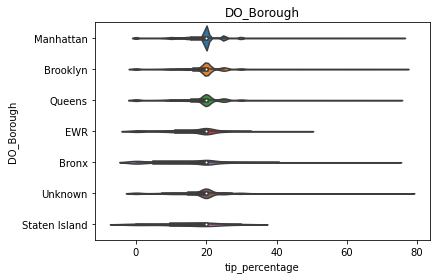

DO_service_zone
+---------------+------------------+------------------+-------------------+--------------------+
|DO_service_zone|avg(fare_amount)  |avg(tip_amount)   |avg(tip_percentage)|avg(duration_in_min)|
+---------------+------------------+------------------+-------------------+--------------------+
|Airports       |40.03333223489997 |8.508452090820375 |18.92021010430394  |35.27034457424144   |
|Boro Zone      |20.366705203789326|3.847438357285044 |17.76042839427973  |20.788448166103517  |
|EWR            |68.4885299347955  |12.533358742258214|16.53187926598204  |38.63189005467707   |
|Unknown        |17.398938417333227|3.337830910990803 |18.09427000845175  |16.510150563175223  |
|Yellow Zone    |11.286281654810063|2.336888893518556 |18.772583406951327 |13.137159038720624  |
+---------------+------------------+------------------+-------------------+--------------------+



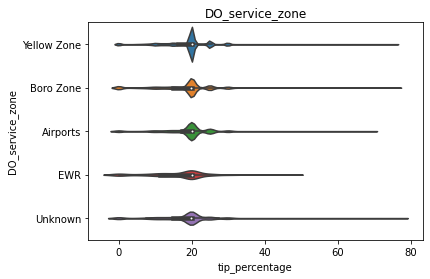

In [4]:
category_columns = ["VendorID", 
    "RateCodeID", "store_and_fwd_flag", 
    "PU_service_zone", "PU_Borough", "DO_Borough", "DO_service_zone"] 

for column in category_columns:
    print(column)
    psdf_taxi.groupBy(column)\
        .avg("fare_amount", "tip_amount", "tip_percentage", "duration_in_min")\
        .orderBy(column).show(truncate=False)
    ax = sns.violinplot(data=df_taxi, 
        x = "tip_percentage",
        y = column, orient='h')
    ax.set_title(column)
    plt.show()   

- RateCodeID = 1 (Standard rate) has the lowest fare and tip, but the highest tip percentage
- RateCodeID = 2 (JFK) has high tip percentage as standard rate
- RateCodeID = 2 and 3 (Airports JFK and Newark) have the highest tip amount
- RateCodeID = 5 (Negotiated fare) has the lowest tip amount and percentage
- RateCodeID = 6 (Group ride) is barely existent
- Bronx and EWR have the lowest tip percentage

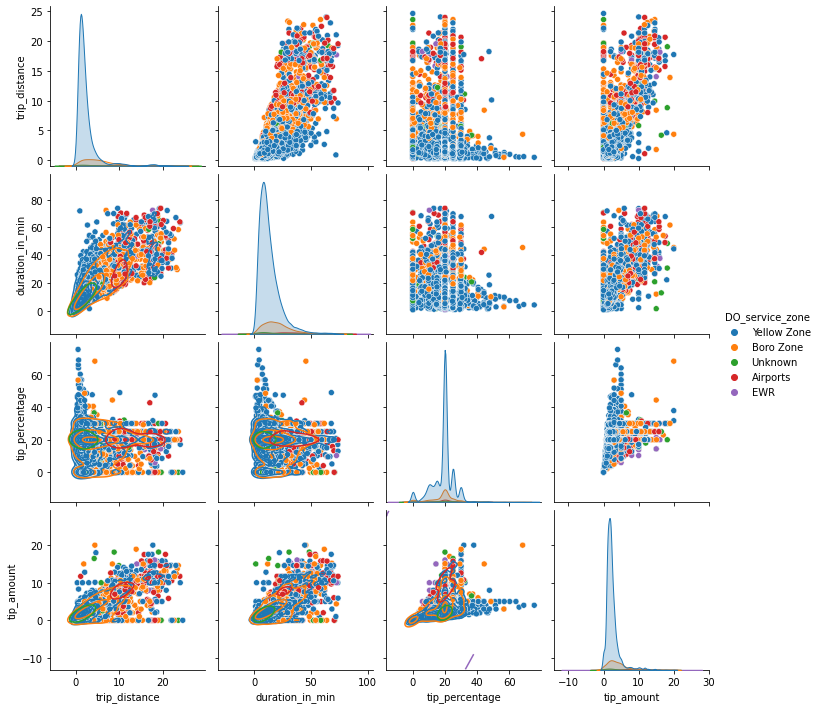

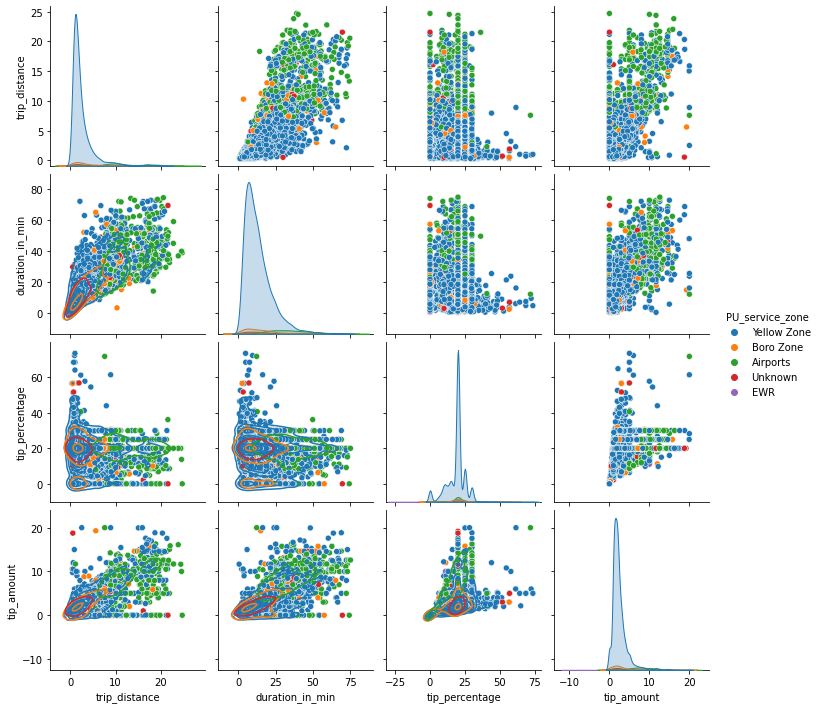

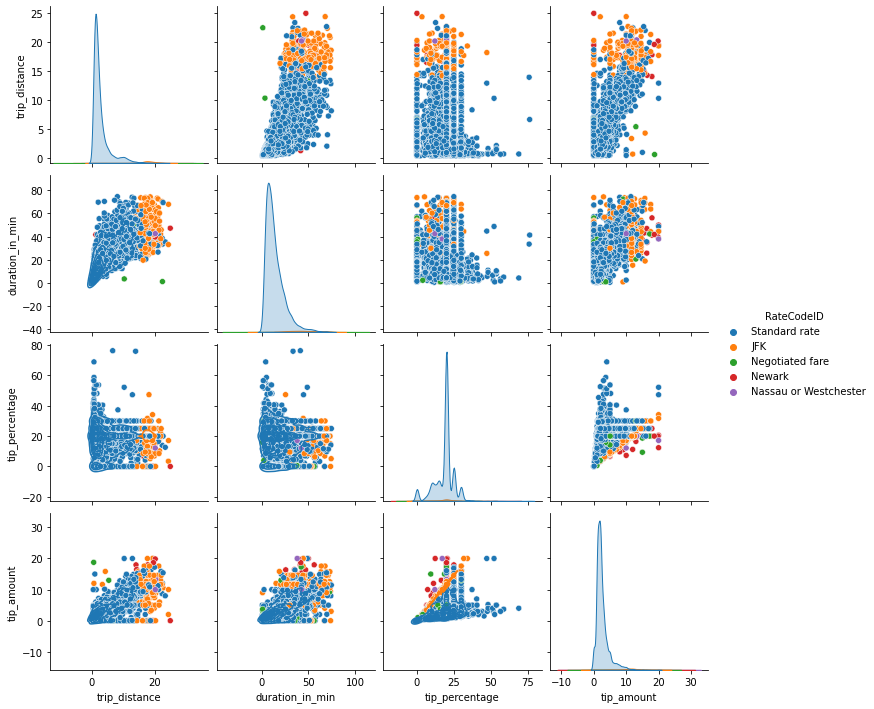

In [5]:
import warnings
warnings.filterwarnings('ignore')

columns_to_check = ["DO_service_zone", "PU_service_zone", "RateCodeID"]

for column in columns_to_check:
    g = sns.pairplot(df_taxi.sample(n=10000)[[column,
            "trip_distance", 
            "duration_in_min",
            "tip_percentage",
            "tip_amount"
            ]], 
        hue=column,  diag_kind="kde")

    g.map_lower(sns.kdeplot)
    plt.show()

<AxesSubplot:>

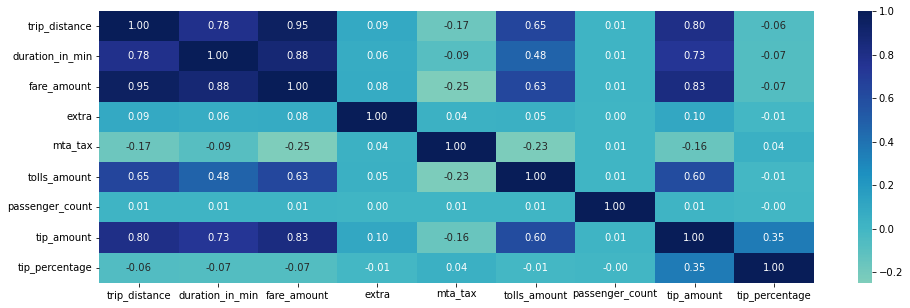

In [6]:
# Check correlation between numeric variables
plt.figure(figsize = (16,5))
sns.heatmap(df_taxi[[
        "trip_distance", 
        "duration_in_min",
        "fare_amount",
        "extra", 
        "mta_tax",         
        "tolls_amount",         
        "passenger_count",         
        "tip_amount", 
        "tip_percentage",         
        ]].corr(), cmap="YlGnBu", annot=True, fmt=".2f", center=0)

- Features whith higher correlation with tip_amount are: fare_amount, trip_distance and duration_in_min
- mta_tax has a little negative correlation with tip_amount
- tip_percentage only has some correlation with tip_amount
- as expected we can see high correlations between trip_distance, duration_in_min, fare_amount

### Map visualizations

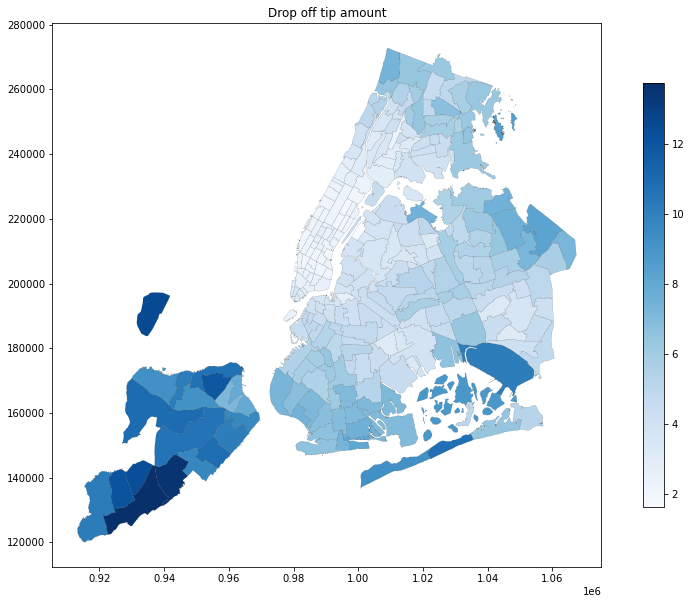

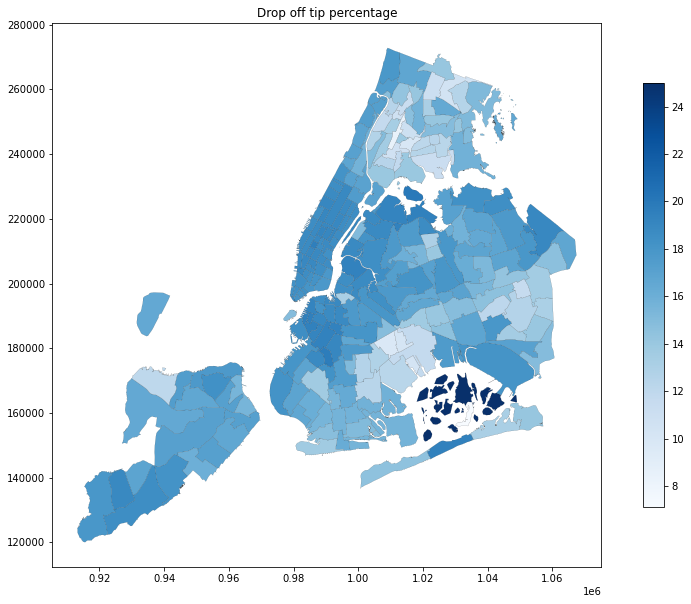

In [7]:
# Plot drop off zones 
psdf_taxi_DO_zone = psdf_taxi.groupBy(["DO_zone", "DOLocationID"]).\
    avg("total_amount", "tip_amount", "tip_percentage")
df_taxi_DO_zone = psdf_taxi_DO_zone.toPandas()

gdf_zones_shp_DO_stats = gdf_zones_shp.merge(
    df_taxi_DO_zone,
    right_on="DOLocationID",
    left_on="OBJECTID")

gdf_zones_shp_DO_stats["avg(tip_amount)"] = round(gdf_zones_shp_DO_stats["avg(tip_amount)"],2)

vis.plot_geomap(gdf_zones_shp_DO_stats, "avg(tip_amount)", 
    "Drop off tip amount")

vis.plot_geomap(gdf_zones_shp_DO_stats, "avg(tip_percentage)", 
    "Drop off tip percentage")


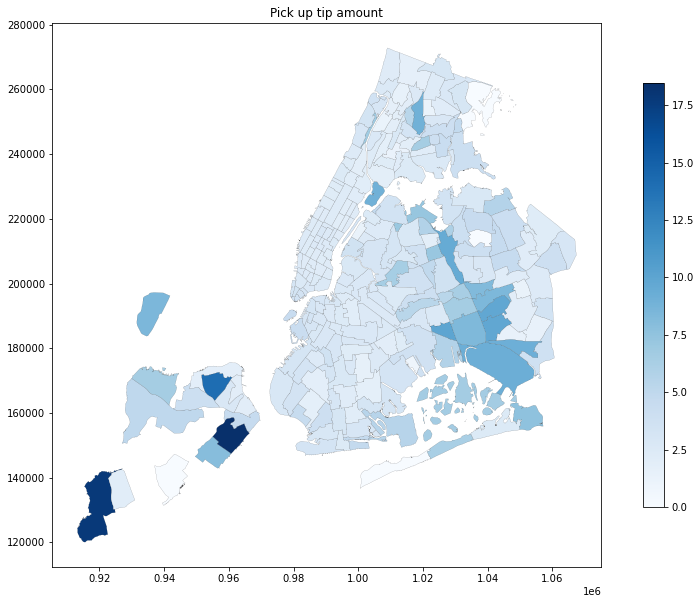

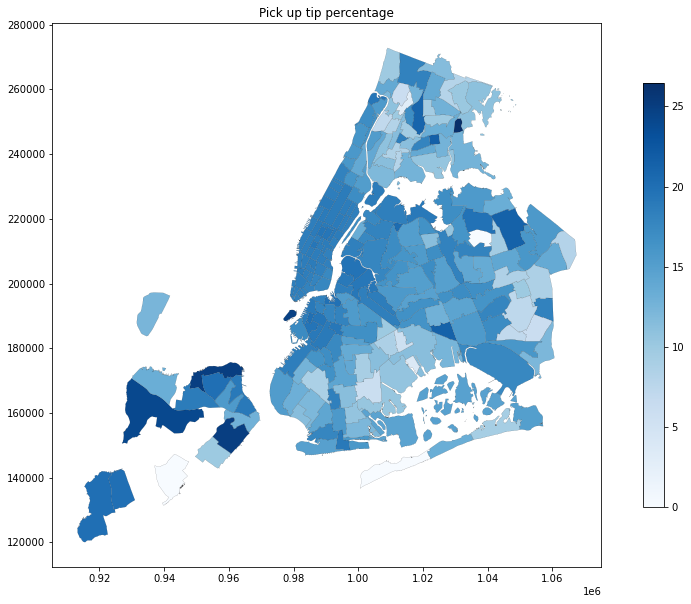

In [8]:
# Plot pick up zones 
psdf_taxi_PU_zone = psdf_taxi.groupBy(["PU_zone", "PULocationID"]).\
    avg("total_amount", "tip_amount", "tip_percentage")
df_taxi_PU_zone = psdf_taxi_PU_zone.toPandas()

gdf_zones_shp_PU_stats = gdf_zones_shp.merge(
    df_taxi_PU_zone,
    right_on="PULocationID",
    left_on="OBJECTID")

gdf_zones_shp_PU_stats["avg(tip_amount)"] = round(gdf_zones_shp_PU_stats["avg(tip_amount)"],2)

vis.plot_geomap(gdf_zones_shp_PU_stats, "avg(tip_amount)", 
    "Pick up tip amount")

vis.plot_geomap(gdf_zones_shp_PU_stats, "avg(tip_percentage)", 
    "Pick up tip percentage")

### Temporal analysis

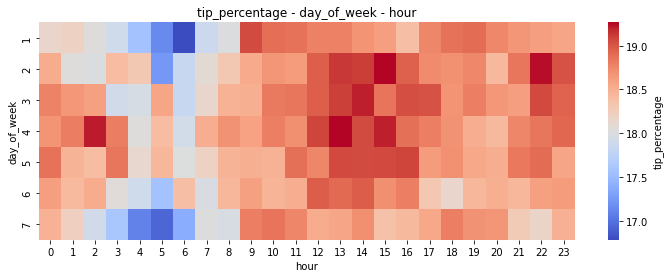

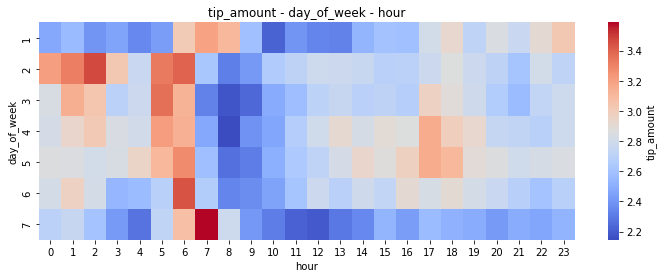

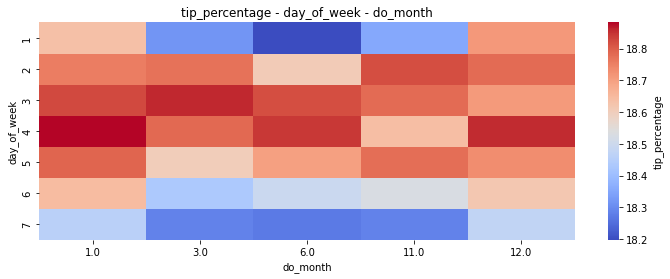

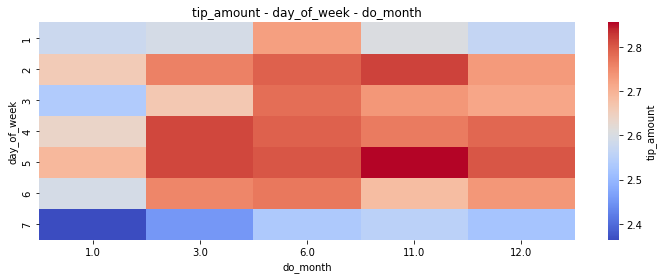

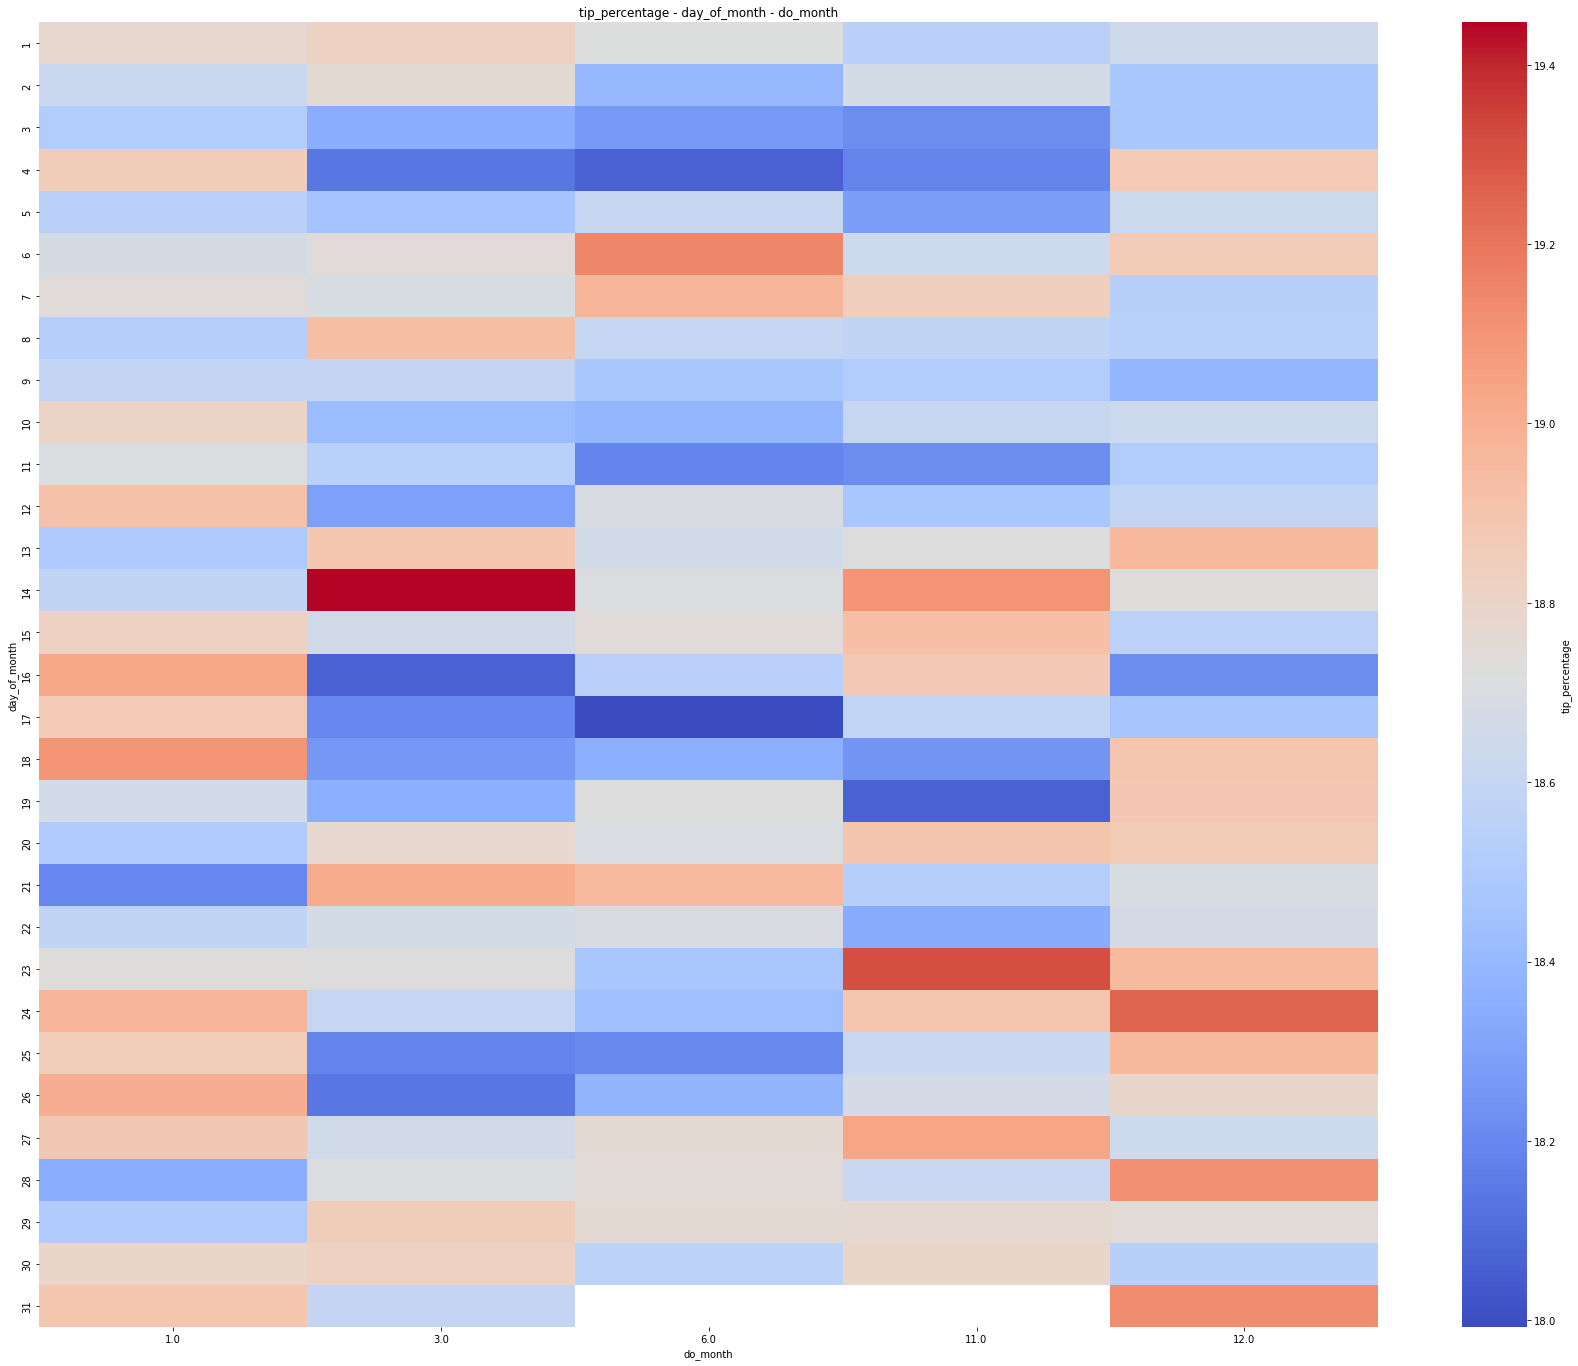

In [9]:
vis.plot_pivot_table_heatmap(df_taxi, 'day_of_week', 'hour', 'tip_percentage')
vis.plot_pivot_table_heatmap(df_taxi, 'day_of_week', 'hour', 'tip_amount')
vis.plot_pivot_table_heatmap(df_taxi, 'day_of_week', 'do_month', 'tip_percentage')
vis.plot_pivot_table_heatmap(df_taxi, 'day_of_week', 'do_month', 'tip_amount')
vis.plot_pivot_table_heatmap(df_taxi, 'day_of_month', 'do_month', 'tip_percentage')

### Route analyisis

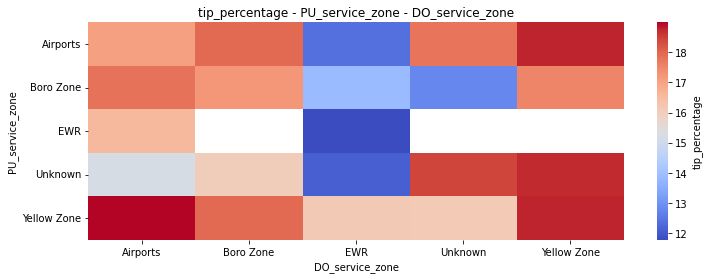

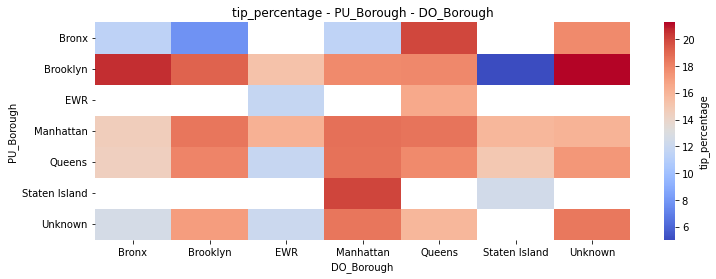

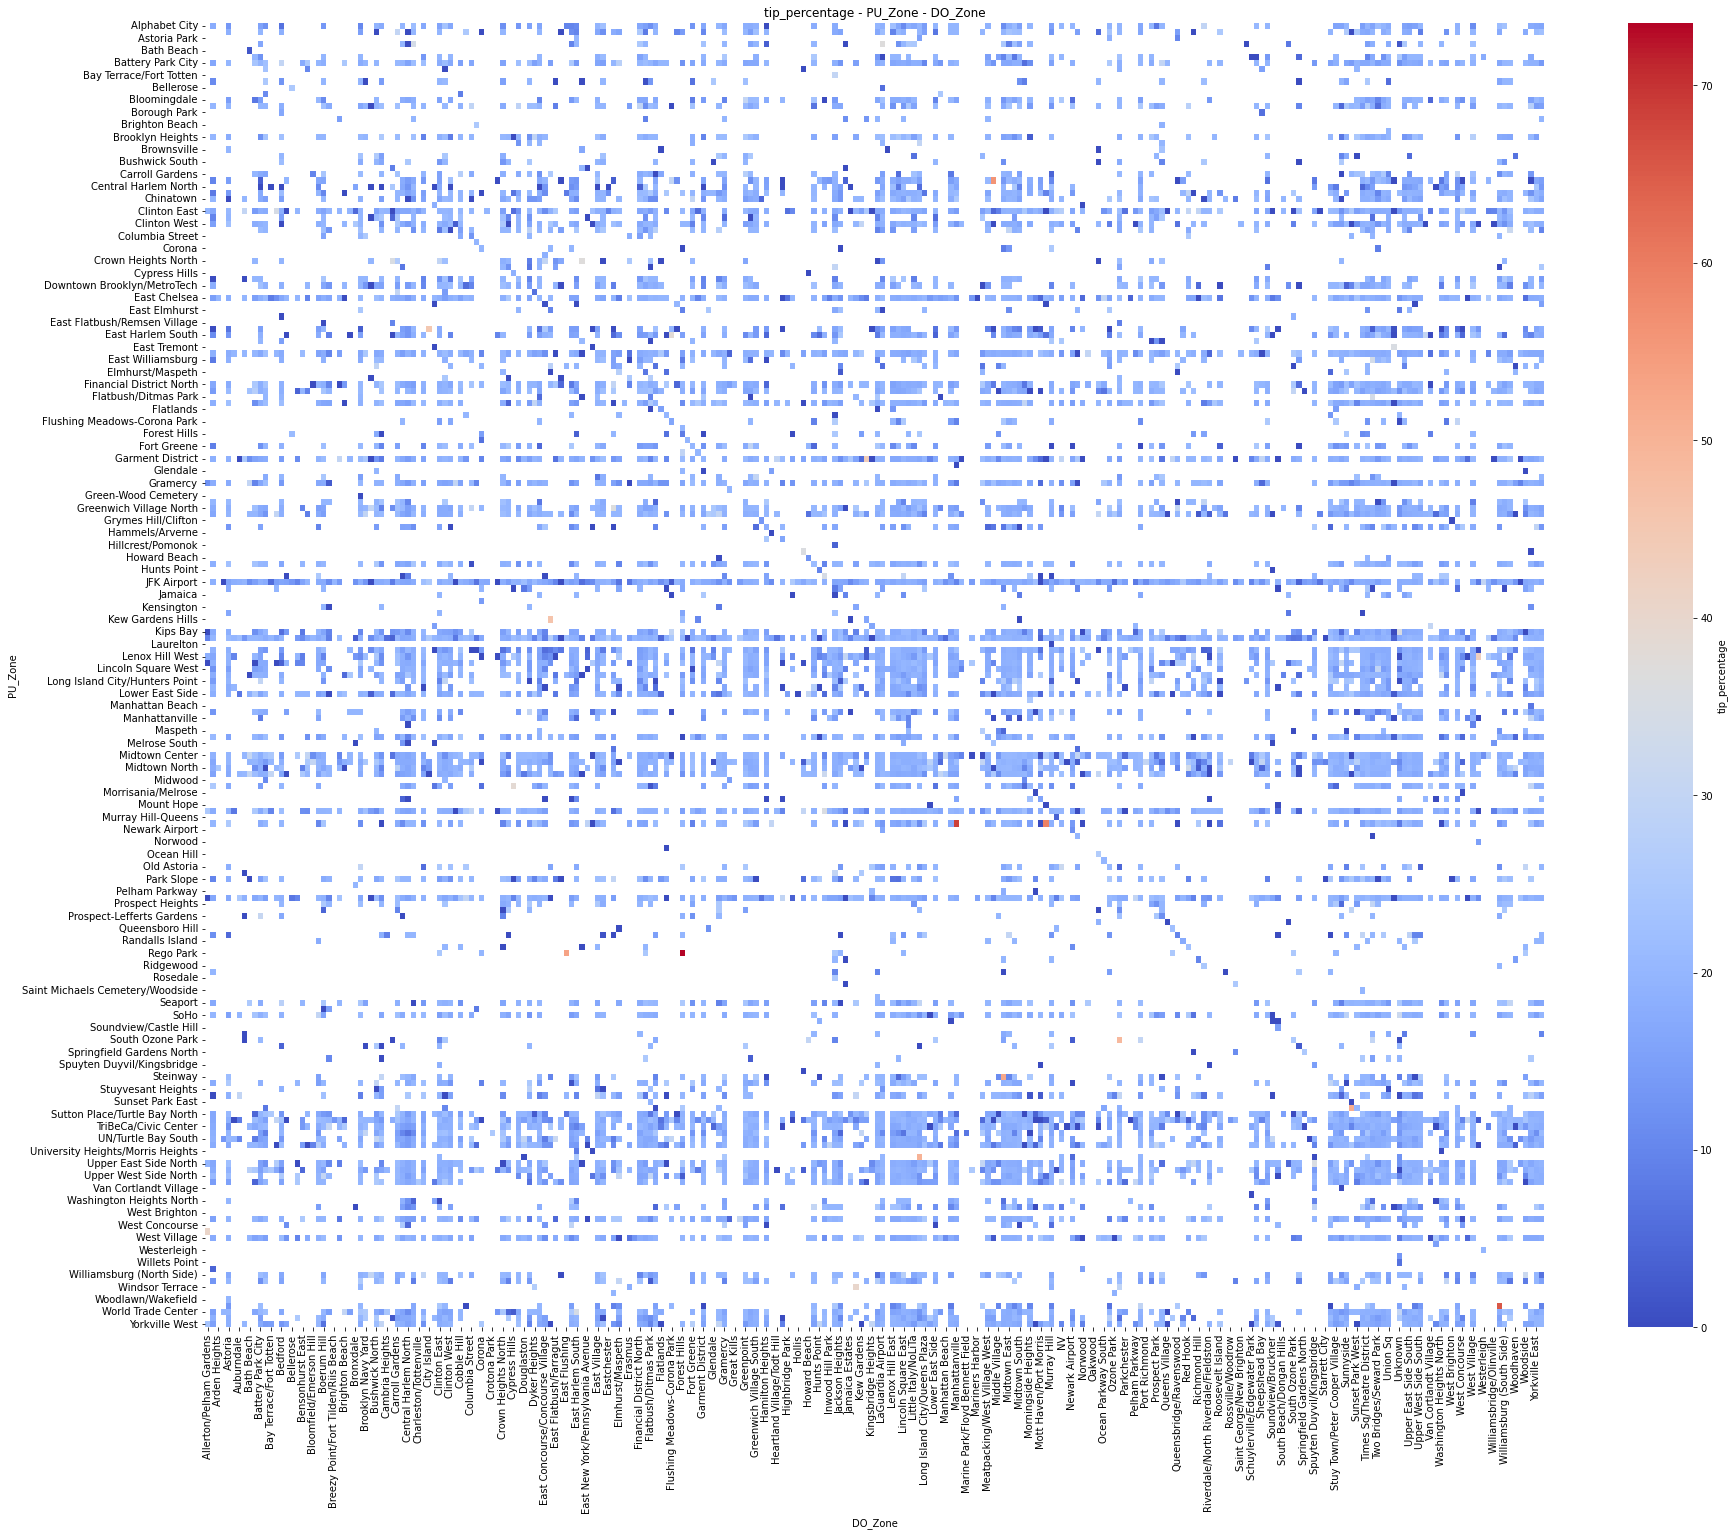

In [10]:
# plot the tip percentage based on the route
vis.plot_pivot_table_heatmap(df_taxi, 'PU_service_zone', 'DO_service_zone', 'tip_percentage')
vis.plot_pivot_table_heatmap(df_taxi, 'PU_Borough', 'DO_Borough', 'tip_percentage')
vis.plot_pivot_table_heatmap(df_taxi, 'PU_Zone', 'DO_Zone', 'tip_percentage')


- we can see that the route of the trip it might effect the results
- be aware that we might suffer from scarcity of the data, since this plots are created with samples